In [1]:
using LinearAlgebra, CairoMakie

In [17]:
function create_model(;nk = 101)

    p = (;α = 0.33,  #Capital share
        β = 0.9, # Discount factor
        γ = 2.0, # Risk aversion
        δ = 0.1, # Dep rate
        A = 2.0, # Productivity
        nk = nk, # Number of grid points
        kmin = 0.75, # Lower bound of capital grid
        kmax = 1.25, # Upper bound of capital grid
        kgrid = zeros(Float64, nk), # Initialise capital grid
        Kss = 0.0, # Initialise steady state capital
        maxiter = 10_000, # Maximum number of iterations
        print_skip = 100, # Print every print_skip iterations
        toler = 1e-6, # VFI tolerance
        m = 100) # Number of Howard iterations

        # Create capital grid
        Kss = ((p.A*p.α*p.β)/(1-p.β*(1.0-p.δ)))^(1/(1.0-p.α))
        kgrid = LinRange(p.kmin*Kss, p.kmax*Kss, nk)

        # Return new NamedTuple
        p = (;p..., kgrid = kgrid, Kss = Kss)

        return p
end

model = create_model()

(α = 0.33, β = 0.9, γ = 2.0, δ = 0.1, A = 2.0, nk = 101, kmin = 0.75, kmax = 1.25, kgrid = LinRange{Float64}(4.110704462586478, 6.851174104310797, 101), Kss = 5.480939283448637, maxiter = 10000, print_skip = 100, toler = 1.0e-6, m = 100)

In [3]:
function utility(c, pars)
    (; γ) = pars
    if γ == 1
        return log(c)
    else
        return (c^(1-γ))/(1-γ)
    end
end

function utility_vec(c, pars)
    (; γ) = pars
    if γ == 1
        return log.(c)
    else
        return (c.^(1-γ))./(1-γ)
    end
end

utility_vec (generic function with 1 method)

Iterating...
--------------------
iteration 0 completed with error 0.3600109335743978
--------------------
iteration 100 completed with error 9.41489675376772e-6
--------------------
converged in 123 iterations
--------------------
  0.211235 seconds (32.54 k allocations: 2.296 MiB, 75.29% compilation time)


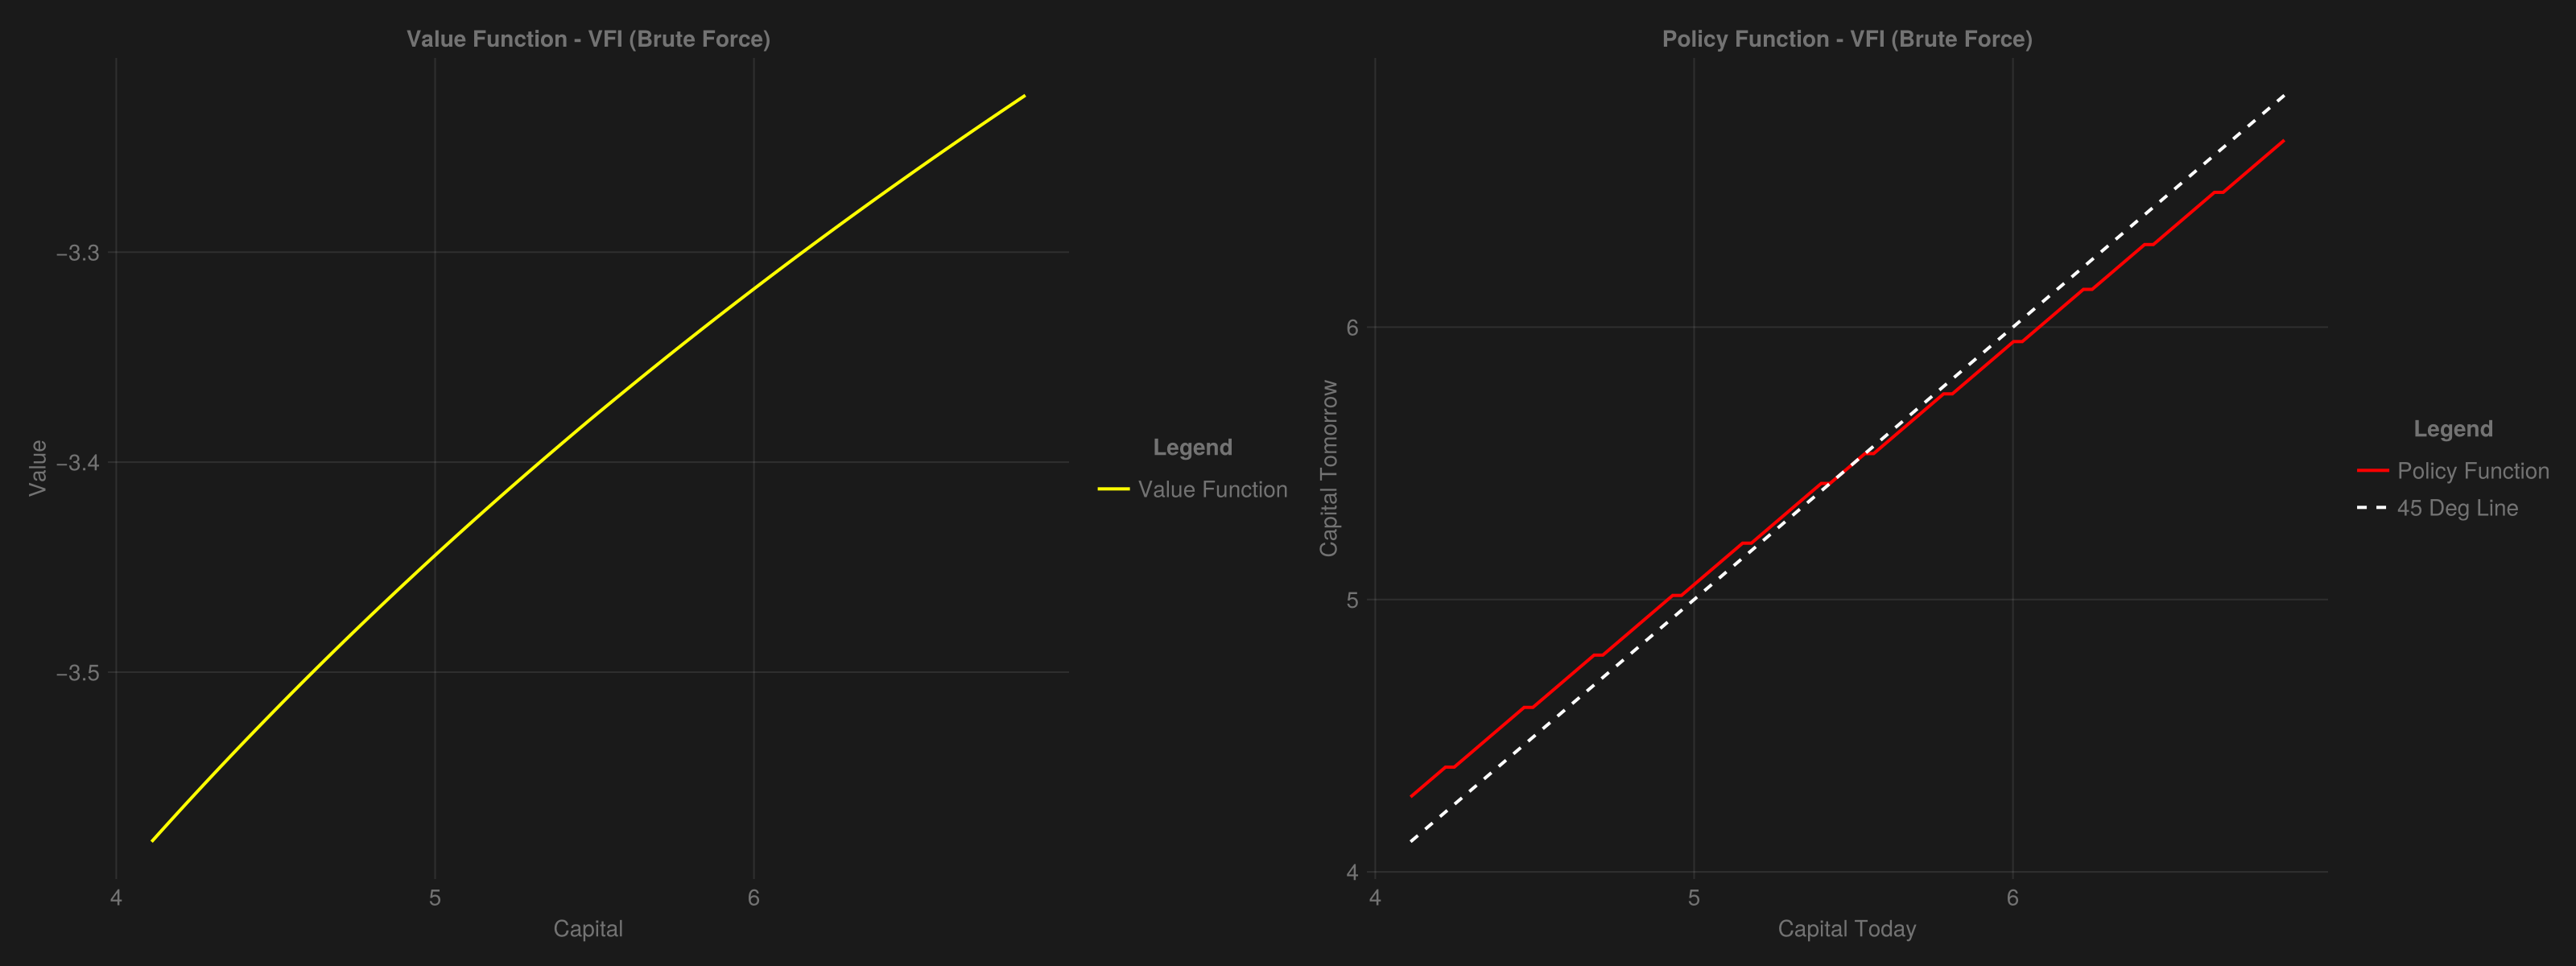

In [51]:
function vfi_nt_brute_force(pars)
    (; α, β, γ, δ, A, kmin, kmax, maxiter, toler, print_skip, Kss, kgrid, nk) = pars
    v = zeros(nk,1)
    v_new = similar(v)
    policy = similar(v)
    dist = zeros(nk,1)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        for i in 1:nk
            vmax = -Inf
            for j in 1:nk
                consump = A*kgrid[i]^α + (1.0-δ)*kgrid[i] - kgrid[j]
                if consump >= 0
                    v_temp = utility(consump, pars) + β*v[j]
                    if v_temp > vmax
                        vmax = v_temp
                        policy[i] = kgrid[j]
                    end
                end
            end
            v_new[i] = vmax
            dist[i] = v_new[i] - v[i]
        end
        error = maximum(abs.(dist))
        if iter % print_skip == 0
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
        v = copy(v_new)
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")
    return v, policy, kgrid
end

@time begin
    v_out_nt, pol_out_nt, grid_out_nt = vfi_nt_brute_force(model)
end

set_theme!(theme_dark())
v = vec(v_out_nt)
pol = vec(pol_out_nt)
grid = vec(grid_out_nt)
fig1 = Figure(size = (1600, 600))
ax1 = Axis(fig1[1, 1], title = "Value Function - VFI (Brute Force)", xlabel = "Capital", ylabel = "Value")
lines!(ax1, grid, v, color = :yellow, linewidth = 2, label = "Value Function")
legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
ax2 = Axis(fig1[1, 3], title = "Policy Function - VFI (Brute Force)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
lines!(ax2, grid, pol, color = :red, linewidth = 2, label = "Policy Function")
lines!(ax2, grid, grid, color = :white, linestyle = :dash, linewidth = 2, label = "45 Deg Line")
legend = Legend(fig1[1, 4], ax2, "Legend", orientation = :vertical)
fig1

Iterating...
--------------------
iteration 0 completed with error 0.3600109335743978
--------------------
iteration 100 completed with error 9.414896753323632e-6
--------------------
converged in 123 iterations
--------------------
  0.728915 seconds (320.75 k allocations: 38.683 MiB, 97.32% compilation time)


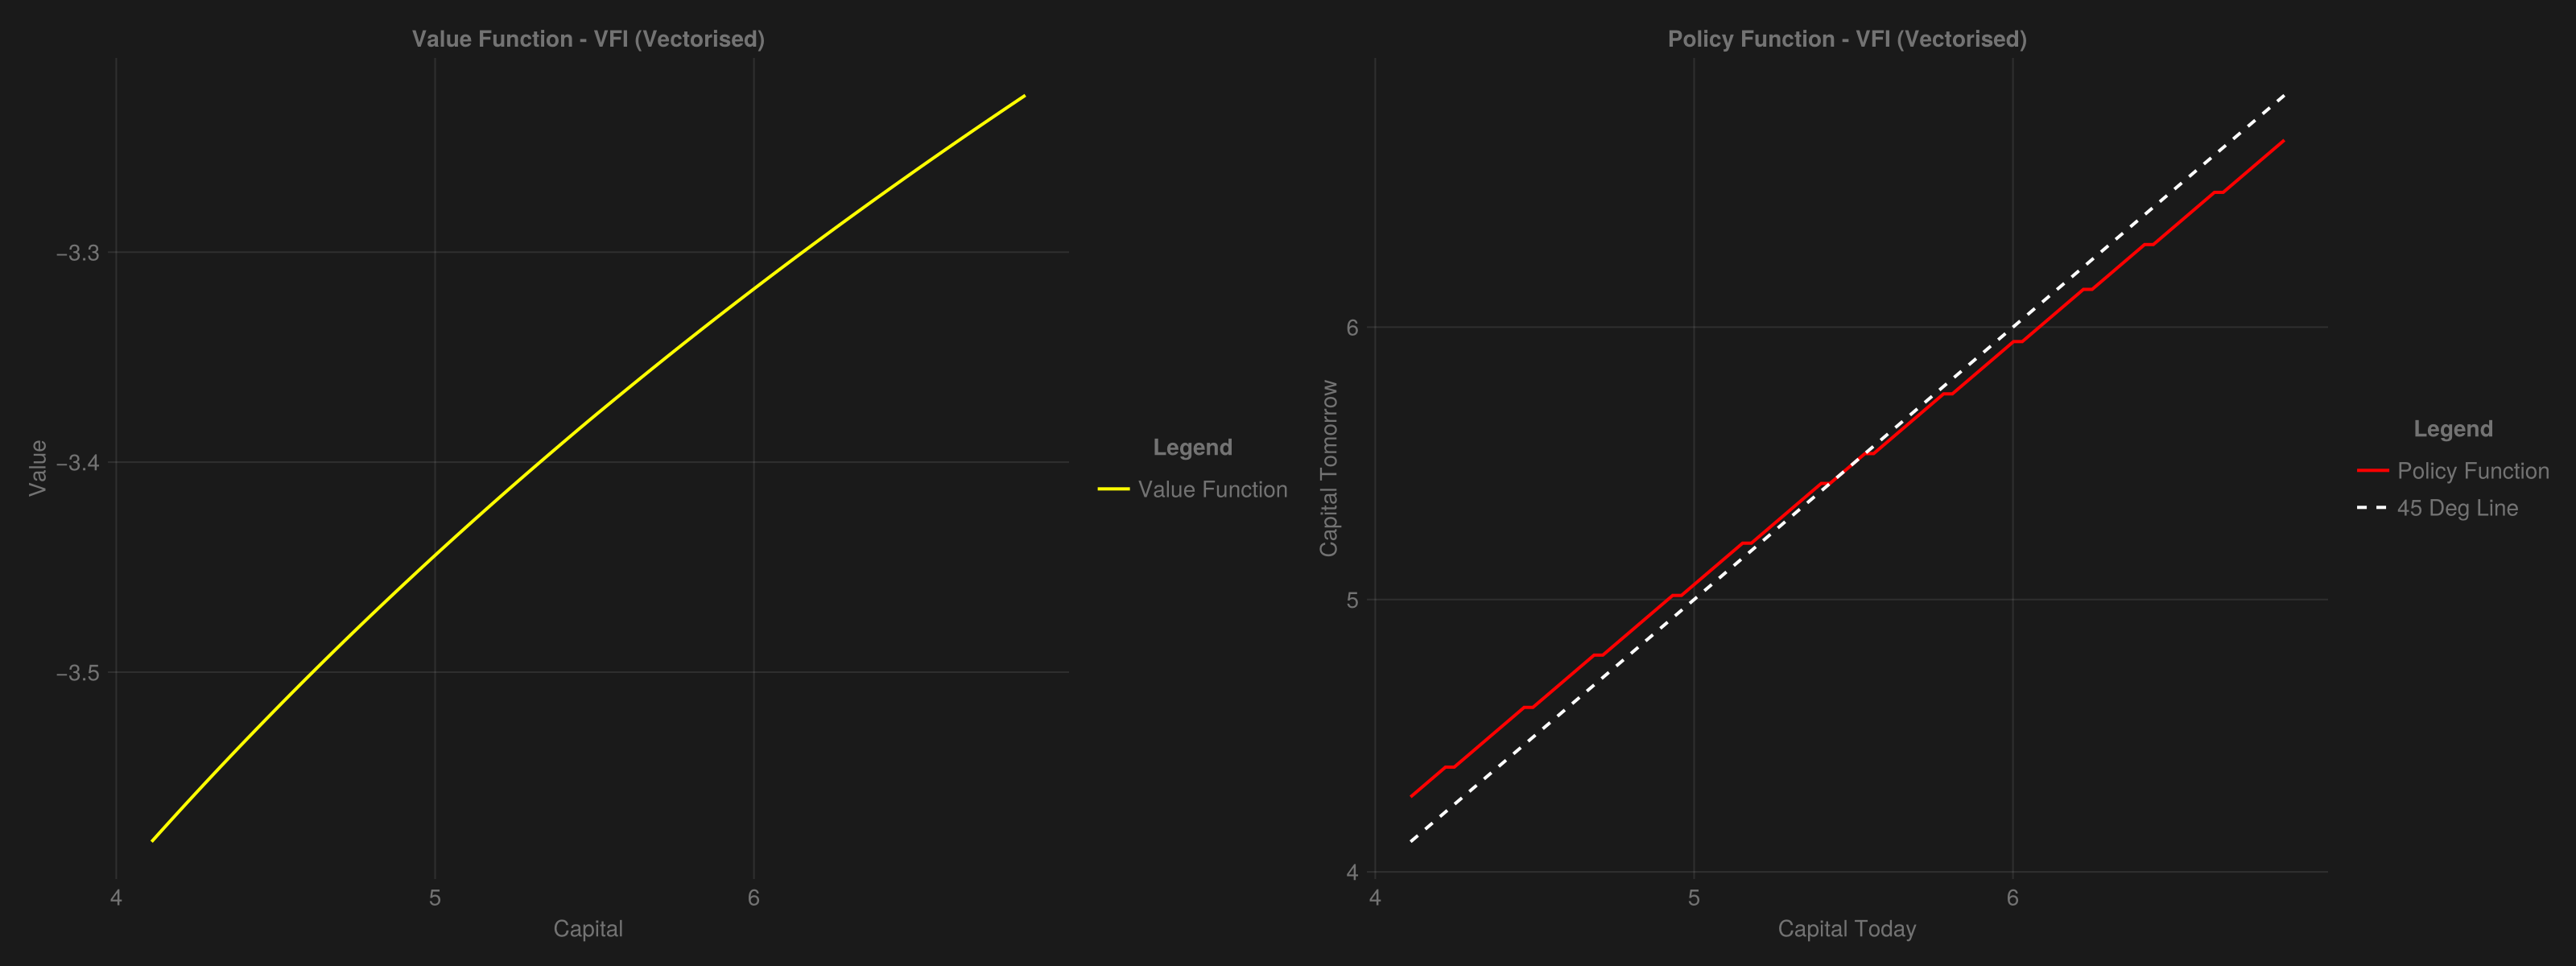

In [50]:
function vfi_nt_vectorised(pars)
    (; α, β, γ, δ, A, kmin, kmax, maxiter, toler, print_skip, Kss, kgrid, nk) = pars
    v = zeros(nk,1)
    v_new = zeros(nk,nk)
    policy = similar(v)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    cons = A.*kgrid.^α .+ (1.0-δ).*kgrid .- transpose(kgrid)
    c_pos = cons .> 0
    pos_c = cons .* c_pos
    while ((error > toler) && (iter < maxiter))
        v_new = utility_vec(pos_c, pars) .+ β.*transpose(v)
        v_new[.!c_pos] .= -Inf
        vmax, vmax_indices = findmax(v_new, dims=2)
        index = getindex.(vmax_indices, [1 2])
        policy = kgrid[index[:,2]] 
        error = maximum(abs.(vmax .- v))
        v .= vmax
        if iter % print_skip == 0
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")
    return v, policy, kgrid
end

@time begin
    v_out_nt_vec, pol_out_nt_vec, grid_out_nt_vec = vfi_nt_vectorised(model)
end

v = vec(v_out_nt_vec)
pol = vec(pol_out_nt_vec)
grid = vec(grid_out_nt_vec)
fig1 = Figure(size = (1600, 600))
ax1 = Axis(fig1[1, 1], title = "Value Function - VFI (Vectorised)", xlabel = "Capital", ylabel = "Value")
lines!(ax1, grid, v, color = :yellow, linewidth = 2, label = "Value Function")
legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
ax2 = Axis(fig1[1, 3], title = "Policy Function - VFI (Vectorised)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
lines!(ax2, grid, pol, color = :red, linewidth = 2, label = "Policy Function")
lines!(ax2, grid, grid, color = :white, linestyle = :dash, linewidth = 2, label = "45 Deg Line")
legend = Legend(fig1[1, 4], ax2, "Legend", orientation = :vertical)
fig1

Iterating...
--------------------
iteration 0 completed with error 1.6962578935422292
--------------------
converged in 61 iterations
--------------------
  0.350145 seconds (55.18 k allocations: 3.535 MiB, 91.26% compilation time)


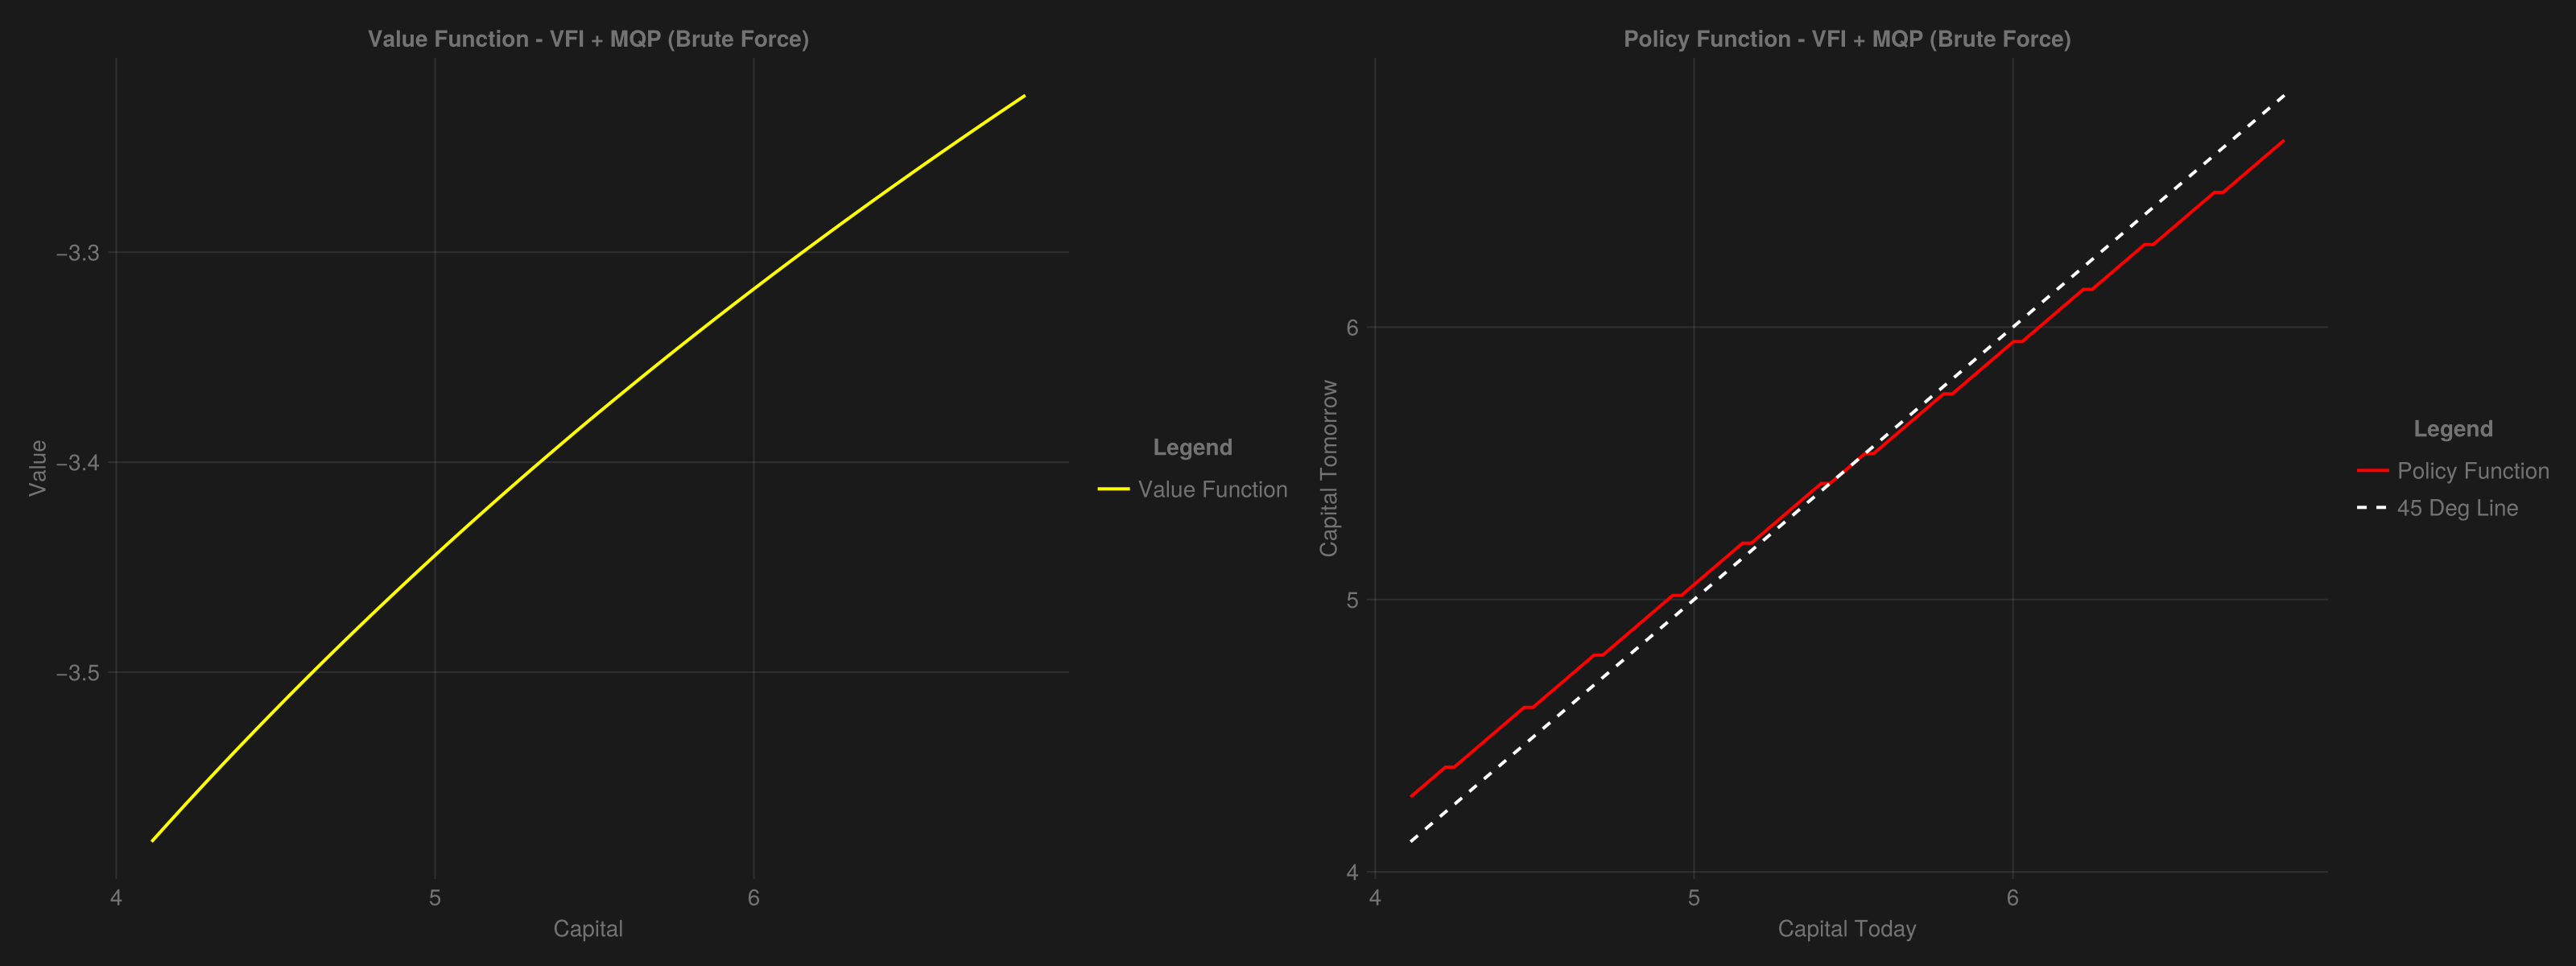

In [49]:
function mqp_nt_brute_force(pars)
    (; α, β, γ, δ, A, kmin, kmax, maxiter, toler, print_skip, Kss, kgrid, nk) = pars
    v = zeros(nk,1)
    v_new = similar(v)
    policy = similar(v)
    dist = zeros(nk,1)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        for i in 1:nk
            vmax = -Inf
            for j in 1:nk
                consump = A*kgrid[i]^α + (1.0-δ)*kgrid[i] - kgrid[j]
                if consump >= 0
                    v_temp = utility(consump, pars) + β*v[j]
                    if v_temp > vmax
                        vmax = v_temp
                        policy[i] = kgrid[j]
                    end
                end
            end
            v_new[i] = vmax
            dist[i] = v_new[i] - v[i]
        end
        low_bound = minimum(v_new .- v) .* (β / (1 - β))
        high_bound = maximum(v_new .- v) .* (β / (1 - β))
        error = high_bound - low_bound
        if iter % print_skip == 0
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
        v = copy(v_new) .+ (low_bound + high_bound)/2
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")
    return v, policy, kgrid
end

@time begin
    v_mqp_nt, pol_mqp_nt, grid_mqp_nt = mqp_nt_brute_force(model)
end

v = vec(v_mqp_nt)
pol = vec(pol_mqp_nt)
grid = vec(grid_mqp_nt)
fig1 = Figure(size = (1600, 600))
ax1 = Axis(fig1[1, 1], title = "Value Function - VFI + MQP (Brute Force)", xlabel = "Capital", ylabel = "Value")
lines!(ax1, grid, v, color = :yellow, linewidth = 2, label = "Value Function")
legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
ax2 = Axis(fig1[1, 3], title = "Policy Function - VFI + MQP (Brute Force)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
lines!(ax2, grid, pol, color = :red, linewidth = 2, label = "Policy Function")
lines!(ax2, grid, grid, color = :white, linestyle = :dash, linewidth = 2, label = "45 Deg Line")
legend = Legend(fig1[1, 4], ax2, "Legend", orientation = :vertical)
fig1

Iterating...
--------------------
iteration 0 completed with error 1.6962578935422292
--------------------
converged in 61 iterations
--------------------
  0.010678 seconds (1.44 k allocations: 10.323 MiB)


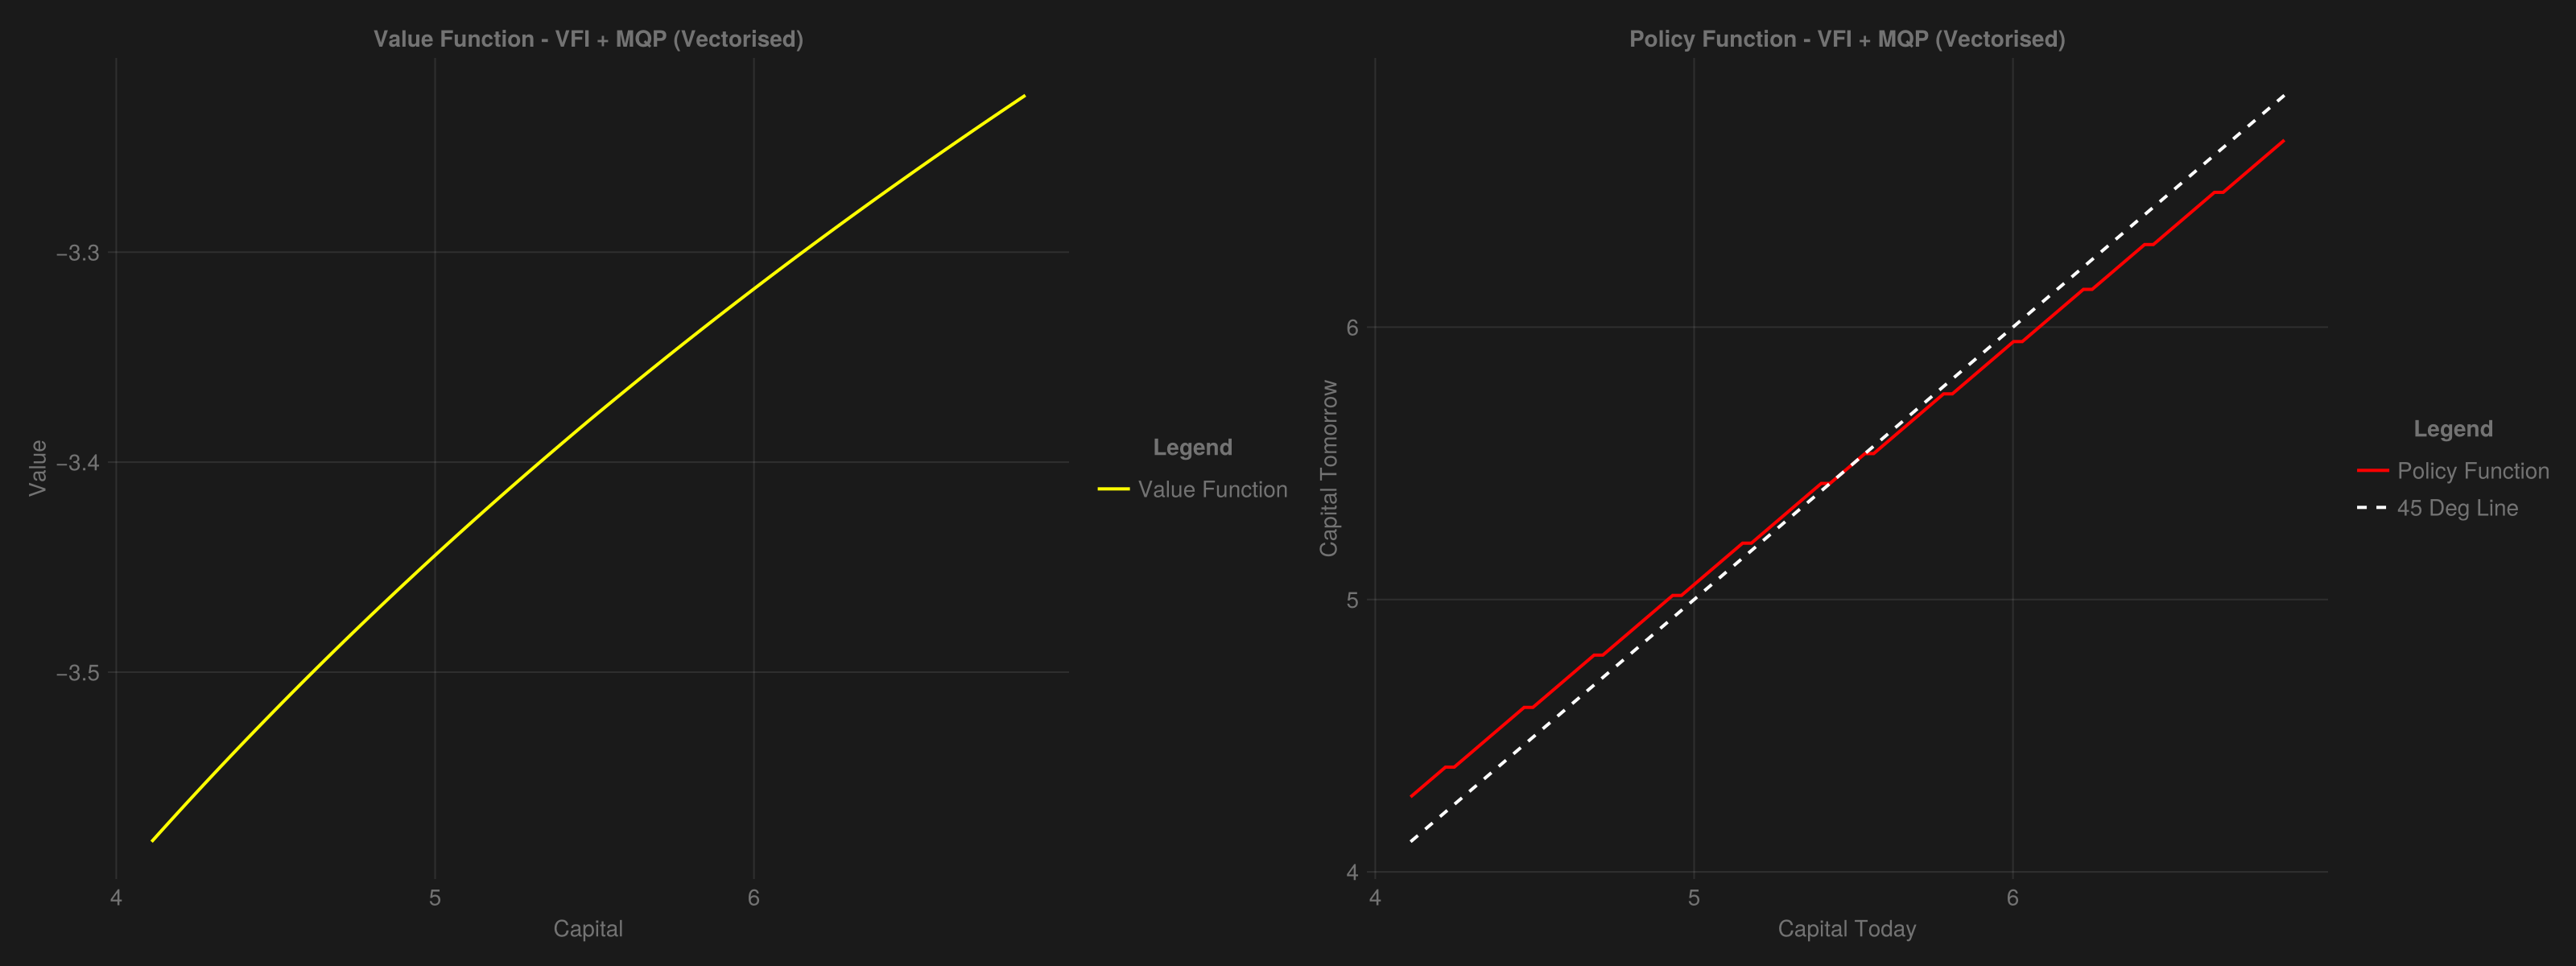

In [52]:
function mqp_nt_vectorised(pars)
    (; α, β, γ, δ, A, kmin, kmax, maxiter, toler, print_skip, Kss, kgrid, nk) = pars
    v = zeros(nk,1)
    v_new = zeros(nk,nk)
    policy = similar(v)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    cons = A.*kgrid.^α .+ (1.0-δ).*kgrid .- transpose(kgrid)
    c_pos = cons .> 0
    pos_c = cons .* c_pos
    while ((error > toler) && (iter < maxiter))
        v_new = utility_vec(pos_c, pars) .+ β.*transpose(v)
        v_new[.!c_pos] .= -Inf
        vmax, vmax_indices = findmax(v_new, dims=2)
        index = getindex.(vmax_indices, [1 2])
        policy = kgrid[index[:,2]] 
        high_bound = maximum(vmax .- v) .* (β / (1 - β))
        low_bound = minimum(vmax .- v) .* (β / (1 - β))
        error = high_bound - low_bound
        if iter % print_skip == 0
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        v .= vmax .+ (low_bound + high_bound)/2
        iter += 1
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")
    return v, policy, kgrid
end

@time begin
    v_mqp_nt_vec, pol_mqp_nt_vec, grid_mqp_nt_vec = mqp_nt_vectorised(create_model())
end 

v = vec(v_mqp_nt_vec)
pol = vec(pol_mqp_nt_vec)
grid = vec(grid_mqp_nt_vec)
fig1 = Figure(size = (1600, 600))
ax1 = Axis(fig1[1, 1], title = "Value Function - VFI + MQP (Vectorised)", xlabel = "Capital", ylabel = "Value")
lines!(ax1, grid, v, color = :yellow, linewidth = 2, label = "Value Function")
legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
ax2 = Axis(fig1[1, 3], title = "Policy Function - VFI + MQP (Vectorised)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
lines!(ax2, grid, pol, color = :red, linewidth = 2, label = "Policy Function")
lines!(ax2, grid, grid, color = :white, linestyle = :dash, linewidth = 2, label = "45 Deg Line")
legend = Legend(fig1[1, 4], ax2, "Legend", orientation = :vertical)
fig1

Iterating...
--------------------
iteration 0 completed with error 3.600023274197883
--------------------
converged in 13 iterations
--------------------
  0.314235 seconds (58.37 k allocations: 4.741 MiB, 95.98% compilation time)


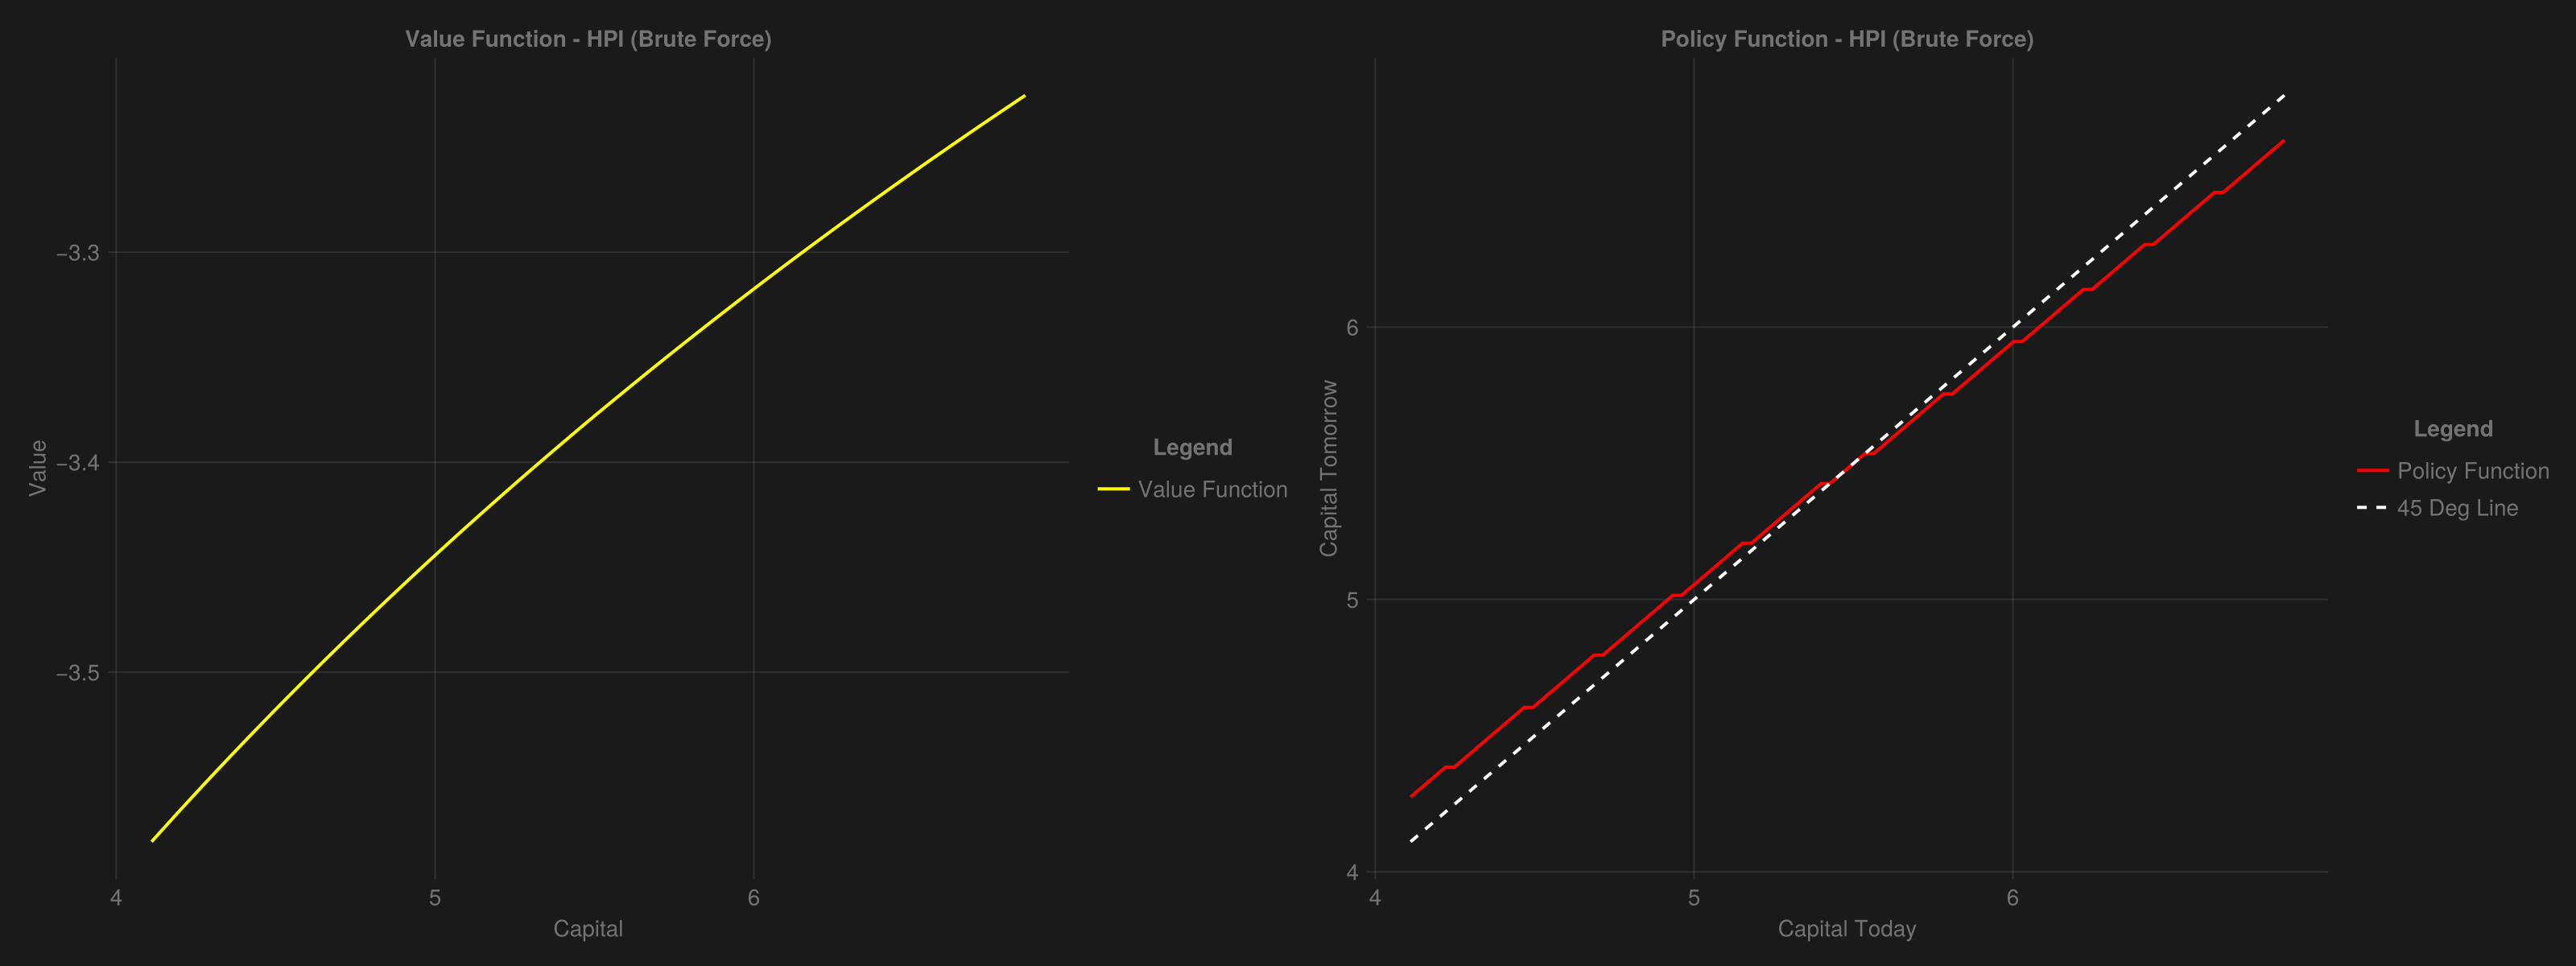

In [54]:
function howard_nt_brute_force(pars)
    (; α, β, γ, δ, A, kmin, kmax, maxiter, toler, print_skip, Kss, kgrid, nk, m) = pars
    v = zeros(nk,1)
    v_new = similar(v)
    v2 = similar(v)
    policy = similar(v)
    idx = zeros(Int, nk,1)
    dist = zeros(nk,1)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        for i in 1:nk
            vmax = -Inf
            for j in 1:nk
                consump = A*kgrid[i]^α + (1.0-δ)*kgrid[i] - kgrid[j]
                if consump >= 0
                    v_temp = utility(consump, pars) + β*v[j]
                    if v_temp > vmax
                        vmax = v_temp
                        policy[i] = kgrid[j]
                        idx[i] = j
                    end
                end
            end
            v_new[i] = vmax
        end
        for _ in 1:m
            for i in 1:nk
                j = idx[i]
                c = A*kgrid[i]^α + (1.0-δ) * kgrid[i] - policy[i]
                v2[i] = utility(c, pars) + β * v_new[j]
            end  
            v_new .= copy(v2)    
        end
        error = maximum(abs.(v_new .- v))
        if iter % print_skip == 0
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
        v = copy(v_new)
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")
    return v, policy, kgrid
end

@time begin
    v_howard_nt, pol_howard_nt, grid_howard_nt = howard_nt_brute_force(model)
end

v = vec(v_howard_nt)
pol = vec(pol_howard_nt)
grid = vec(grid_howard_nt)
fig1 = Figure(size = (1600, 600))
ax1 = Axis(fig1[1, 1], title = "Value Function - HPI (Brute Force)", xlabel = "Capital", ylabel = "Value")
lines!(ax1, grid, v, color = :yellow, linewidth = 2, label = "Value Function")
legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
ax2 = Axis(fig1[1, 3], title = "Policy Function - HPI (Brute Force)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
lines!(ax2, grid, pol, color = :red, linewidth = 2, label = "Policy Function")
lines!(ax2, grid, grid, color = :white, linestyle = :dash, linewidth = 2, label = "45 Deg Line")
legend = Legend(fig1[1, 4], ax2, "Legend", orientation = :vertical)
fig1

Iterating...
--------------------
iteration 0 completed with error 3.600023274197883
--------------------
converged in 13 iterations
--------------------
  1.606327 seconds (896.27 k allocations: 60.235 MiB, 99.34% compilation time)


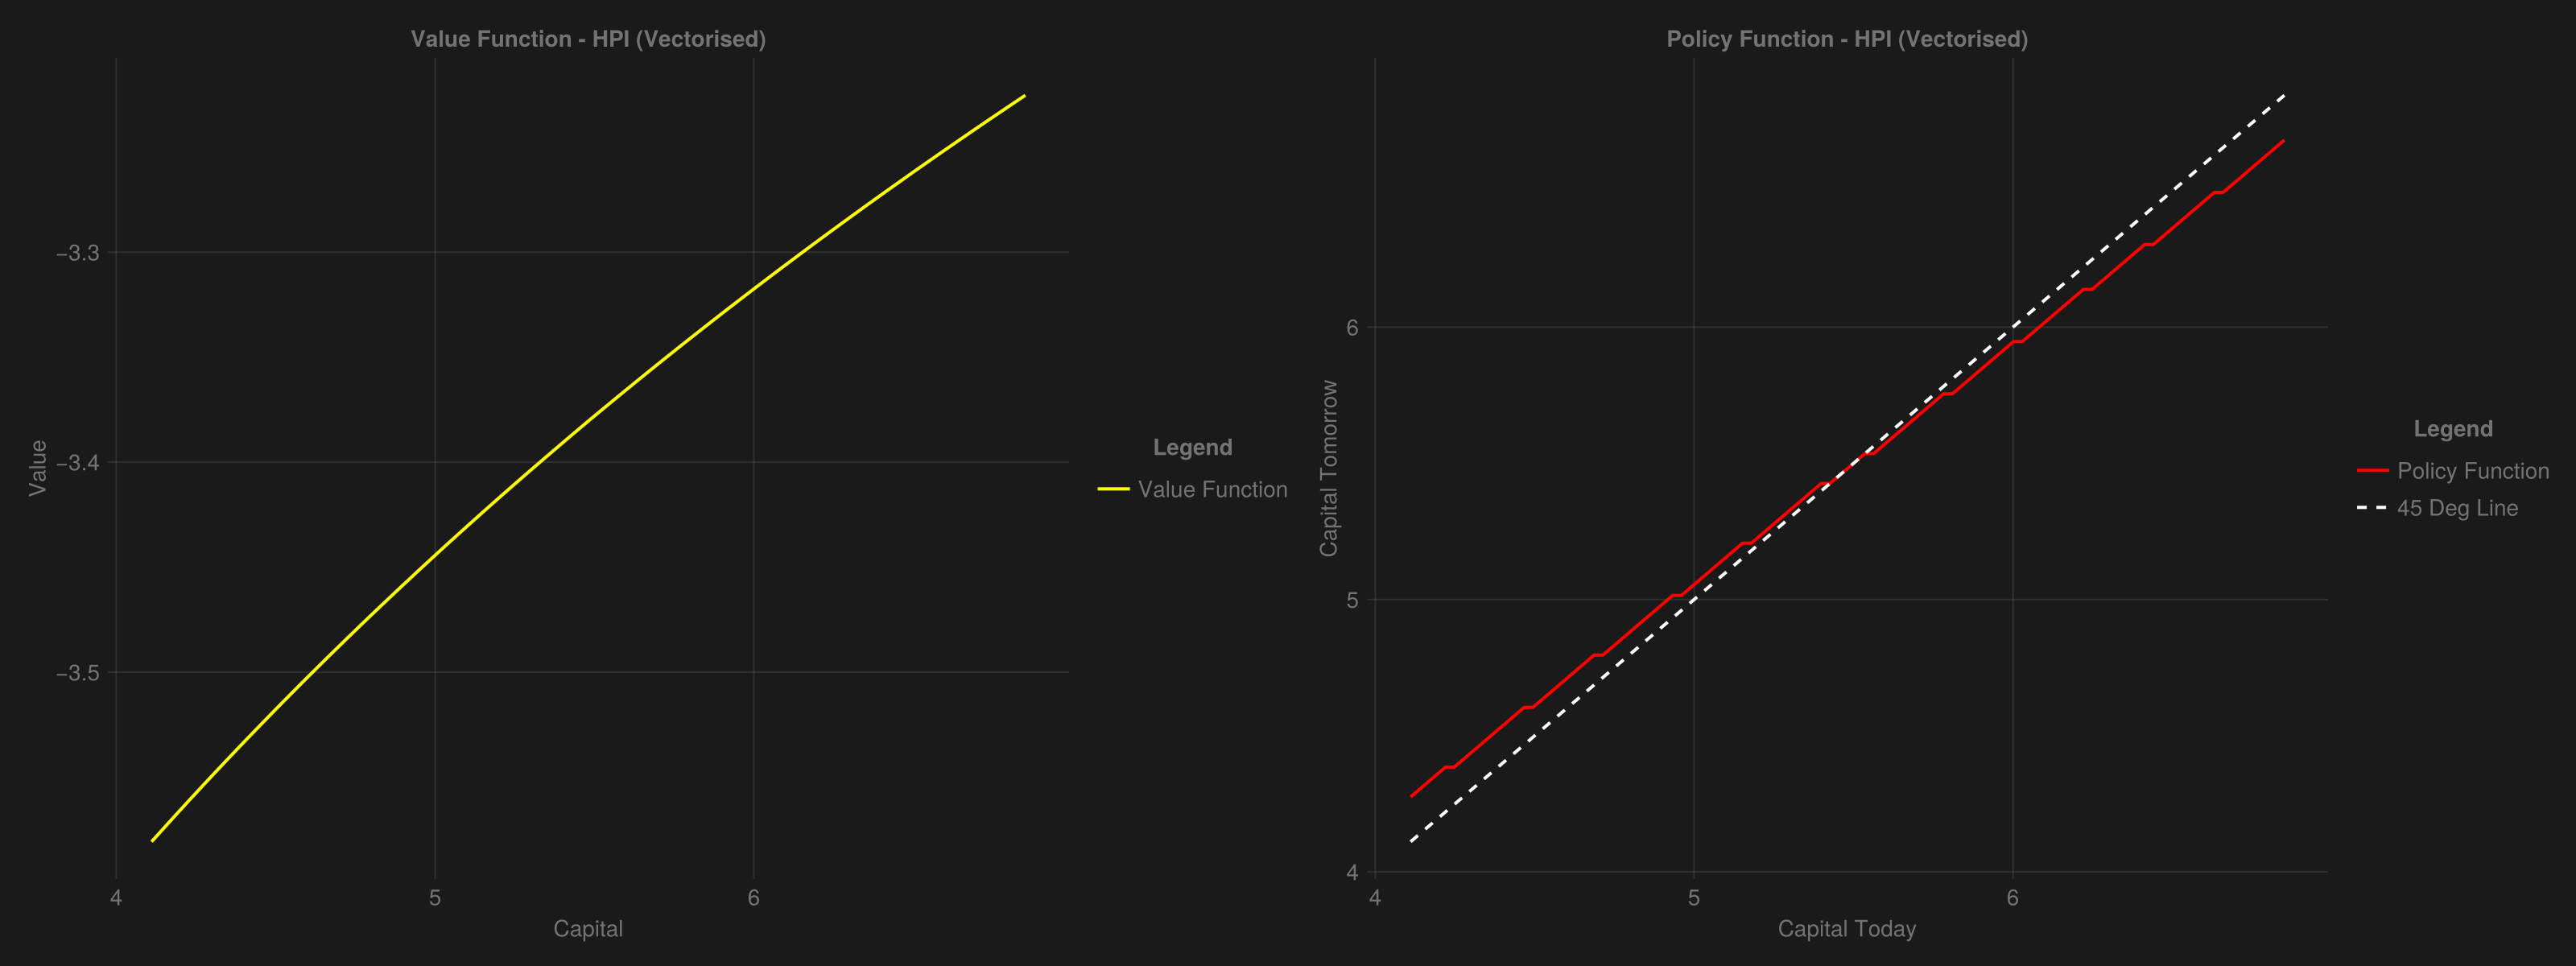

In [59]:
function howard_nt_vectorised(pars)
    (; α, β, γ, δ, A, kmin, kmax, maxiter, toler, print_skip, Kss, kgrid, nk, m) = pars
    v = zeros(nk,1)
    v_new = zeros(nk,nk)
    policy = similar(v)
    vmax = similar(v)
    v_howard = similar(v)
    c_howard = similar(v)
    #Kss = ((A*α*β)/(1-β*(1.0-δ)))^(1/(1.0-α))
    #kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    kgrid = reshape(kgrid, (nk,1))
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    cons = A.*kgrid.^α .+ (1.0-δ).*kgrid .- transpose(kgrid)
    c_pos = cons .> 0
    util = similar(cons)
    util_howard = similar(v)
    util[.!c_pos] .= -Inf
    util[c_pos] = utility_vec(cons[c_pos], pars)
    v_new[.!c_pos] .= -Inf
    while ((error > toler) && (iter < maxiter))
        v_new[c_pos] = util .+ β.*transpose(v)
        vmax, vmax_indices = findmax(v_new, dims=2)
        index = getindex.(vmax_indices, [1 2])
        policy = kgrid[index[:,2]]
        new_c = A .* kgrid.^α .+ (1.0-δ) .* kgrid .- policy
        c_pos_howard = new_c .> 0
        util_howard[.!c_pos_howard] .= -Inf
        for _ in 1:m
            v_howard[c_pos_howard] = utility_vec(new_c[c_pos_howard], pars) .+ β .* vmax[index[:,2]]
            v_howard[.!c_pos_howard] .= -Inf
            vmax .= v_howard
        end
        error = maximum(abs.(vmax .- v))
        v .= vmax
        if iter % print_skip == 0
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")
    return v, policy, kgrid
end

@time begin
    v_howard_nt_vec, pol_howard_nt_vec, grid_howard_nt_vec = howard_nt_vectorised(model)
end

v = vec(v_howard_nt_vec)
pol = vec(pol_howard_nt_vec)
grid = vec(grid_howard_nt_vec)
fig1 = Figure(size = (1600, 600))
ax1 = Axis(fig1[1, 1], title = "Value Function - HPI (Vectorised)", xlabel = "Capital", ylabel = "Value")
lines!(ax1, grid, v, color = :yellow, linewidth = 2, label = "Value Function")
legend = Legend(fig1[1, 2], ax1, "Legend", orientation = :vertical)
ax2 = Axis(fig1[1, 3], title = "Policy Function - HPI (Vectorised)", xlabel = "Capital Today", ylabel = "Capital Tomorrow")
lines!(ax2, grid, pol, color = :red, linewidth = 2, label = "Policy Function")
lines!(ax2, grid, grid, color = :white, linestyle = :dash, linewidth = 2, label = "45 Deg Line")
legend = Legend(fig1[1, 4], ax2, "Legend", orientation = :vertical)
fig1